In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## **The inputs of our System**

In [ ]:
#tragectory length
TLen = 20

#In each step we have four variables (X , Y, X', Y') i.e (postion x, postion y, speed x, speed y)
Pos = np.zeros((4,TLen))

#Initial values for (X , Y, X', Y')
Init = [20,40,2,0.75]  ## X0 for creating the trejectory


#The error (variance)of the model
ModelVar = 0.4

#The error (variance)of the observation i.e measurement
ObsVar = 0.4

'''
covariance matrix of the model which present the error accross the four dimentions
We assumed that 1. The model only have an error 'ModelVar' for x and y.
                2. The four variables are independent i.e we only have values in the diagonal
                3. The variance of the speed is close to 0
'''
CovMod = [[ModelVar,0,0,0],[0,ModelVar,0,0],[0,0,0.001,0],[0,0,0,0.001]]  ## Q


'''
covariance matrix of the measurement which present the error accross the four dimention
We assumed that 1. The measrement only have an error 'ObsVar' for x and y.
                2. The four variables are independent i.e we only have values in the diagonal
                3. The variance of the speed is close to 0
'''
CovMeas = [[ObsVar,0,0,0],[0,ObsVar,0,0],[0,0,0.001,0],[0,0,0,0.001]] ## R


'''
State measurement which present the model equation system as follow:
    1. X(t)  = X(t-1) + X'(t-1)
    2. y(t)  = y(t-1) + y'(t-1)
    3. X'(t) = X'(t-1)
    4. y'(t) = y'(t-1)

We can notice that the equaitons are linear which make Kálmán filter feasible
State Matrix convert our input (previous estimation) to the current model realm
'''
StMat = np.eye(4)  ## A
StMat[0][2]= 1
StMat[1][3]= 1

'''
Observation measurement which present the measurement equation as follow:
    1. x  = X
    2. y  = y
    3. X' = x'
    4. y' = y'

We can notice that the equaitons are linear which make Kálmán filter feasible
Measurement matrix (H) convert the model state to our input(obervatoin) state realm.
'''

MeasMat = np.eye(4) ## H


#initilization values for KAlmen filter
X0 = np.array([18,42,1.8,0.6])
P0 = np.array([[4,0,0,0],[0,4,0,0],[0,0,1,0],[0,0,0,1]])

## **Generate Trajectory**

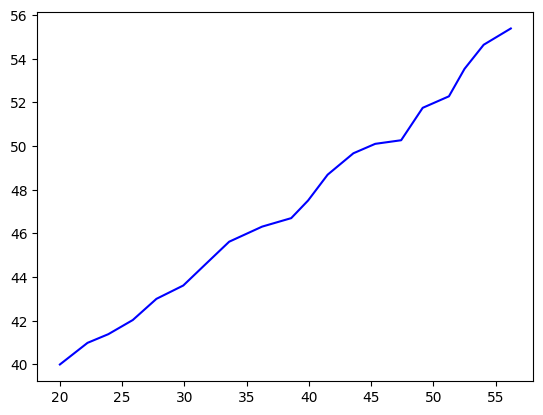

In [ ]:
Pos[:,0]= Init

for i in range(1,TLen):
  Pos[:,i]=np.matmul(StMat,Pos[:,i-1])+np.matmul(CovMod,np.random.normal(0,1,4))


plt.plot(Pos[0,:],Pos[1,:],"b")

## **Generate Observation**

In [ ]:
Obs=np.zeros((2,TLen))

for i in range(TLen):
    Obs[:,i]=Pos[0:2,i]+ ObsVar*np.random.normal(0,1,2)
plt.plot(Pos[0,:],Pos[1,:],"b")
plt.plot(Obs[0,:],Obs[1,:],'g')

## **Predict Correct Filter**

Model initialization

In [ ]:
#we will store our estimation for the four variables at each step
Estimation = np.zeros((4,TLen))
Estimation [:,0] = X0

'''
The easiest solution will be having a fixed preference between the two data sources (our model, the measrement coming from the sensors)
We can define a fixed pramameter tp play as a trade off between beleaving the model or beleaving the measerement
Alpha: how much I beleave my model updating the postion  (x  ,y )
Beta : how much I beleave my model updating the velocity (x' ,y')
'''
Alpha = 0.8
Beta = 0.5

#a vectore containing our trade off parameter for the four variables (X , Y, X', Y')
TradeOff = [Alpha,Alpha,Beta,Beta]

Tajectory estimation

In [ ]:
for i in range(1,TLen):
  #Step update
  Estimation[:,i]= StMat @ Estimation[:,i-1]
  CurrentMeas = [Obs[0,i],Obs[1,i], Obs[0,i]-Obs[0,i-1] ,Obs[1,i]-Obs[1,i-1]]

  #Correction step
  Estimation[:,i]= TradeOff*Estimation[:,i] + (np.ones(4)- TradeOff)*CurrentMeas

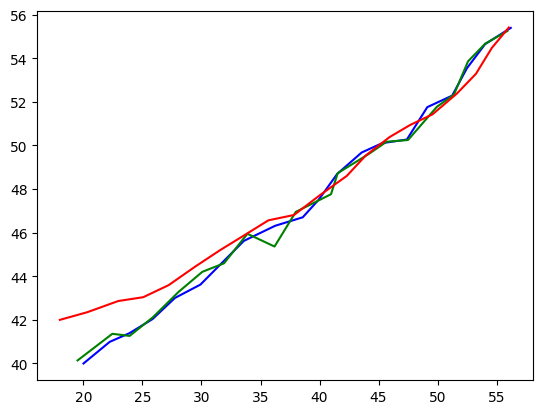

In [ ]:
plt.plot(Pos[0,:],Pos[1,:],"b")
plt.plot(Obs[0,:],Obs[1,:],'g')
plt.plot(Estimation[0,:],Estimation[1,:],'r')

## **Alpha-Beta Filter**

Model initialization

In [ ]:
Estimation = np.zeros((4,TLen))
Estimation [:,0] = X0

TrackingIndex = 0.7

C = (4 + TrackingIndex - np.sqrt(TrackingIndex**2 + 8*TrackingIndex))/4

SAlpha = 1 - C**2

SBeta = TrackingIndex*C

ParametersRef = [SAlpha,SAlpha,SBeta,SBeta]

SMC = 5

G = 1 - np.exp(-1/SMC)

Alpha = 0.3
Beta = 0.1

Parameters = np.zeros((4,TLen))

Parameters[:,0] = [Alpha,Alpha,Beta,Beta]

Tajectory estimation

In [ ]:
for i in range(1,TLen):

  #Step update
  Estimation[:,i]= StMat @ Estimation[:,i-1]
  CurrentMeas = [Obs[0,i],Obs[1,i], Obs[0,i]-Obs[0,i-1] ,Obs[1,i]-Obs[1,i-1]]
  Parameters[:,i] = Parameters[:,i-1] + G*(ParametersRef - Parameters[:,i-1])

  #Correction step
  Estimation[:,i]= Parameters[:,i]*Estimation[:,i] + (np.ones(4)- Parameters[:,i])*CurrentMeas

In [ ]:
plt.plot(Pos[0,:],Pos[1,:],"b")
plt.plot(Obs[0,:],Obs[1,:],'g')
plt.plot(Estimation[0,:],Estimation[1,:],'r')

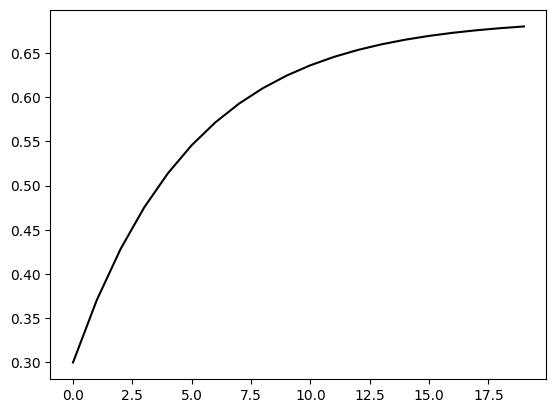

In [ ]:
plt.plot(range(TLen),Parameters[0,:],'k')

## **Kálmán Filter**

Model initialization

In [ ]:
#At each step, we will store our new estimatoin (X) for the four variables (x,y,x',y')
Estimation = np.zeros((4,TLen))
'''
At each step, we will store the new covariance matrix containing the variance (probable error) between the four variables
              P = [[Var(x,x)    Var(x,y)    Var(x,x')    Var(x,y') ]
                   [Var(y,x)    Var(y,y)    Var(y,x')    Var(y,y') ]
                   [Var(x',x)   Var(x',y)   Var(x',x')   Var(x',y')]
                   [Var(y',x)   Var(y',y)   Var(y',x')   Var(y',y')]]
'''
P = np.zeros((4,4,TLen))

#we will initiate our Estimation and our Covariance with realistic values
Estimation [:,0]   = X0
P [:,:,0]          = P0

### **Implementation Help**

#### Step update
- The model based estimation is the same as before
- P: Covariance Matrix update for the estimate can be done in a quadratic form: P[t] = StMat @ P[t-1] @ StMat.T + ModelCovarianceMatrix.

  This will represent the estimation confidence of the model.
- Measurement is the same as before

#### Calculate Kalman Gain
- The gain will represent the ratio between what information we can get from the Model and what we can get from the Measurement.
- Variable names:
  - H: Measurement Matrix
  - K: Kalman gain
  - P: Covariance Matrix (as calculated before)
  - C_meas: Measurement Covariance Matrix
- In the measurement space this would be: H @ K = ( H @ P @ H.T ) / ( H @ P @ H.T + C_meas )
- But we want it in the hidden space, which is a multiplication with H, therefore: K = ( P @ H.T ) / ( H @ P @ H.T + C_meas )

#### Correction step

- Update on the Estimate similarly as before, but using the Kalman gain:

  Estimation[t] = Estimation[t] + KalmanGain @ (CurrentMeasurement - MeasurementMatrix @ Estimation[t])
- Also updating the P Covariance Matrix, like:

  P[t] = ( UnitMatrix - KalmanGain @ MeasurementMatrix ) @ P[t]

In [ ]:
#@title Trajectory Estimation - Kalman Filter

for i in range(1,TLen):
  #Step update
  Estimation[:,i] = StMat @ Estimation[:,i-1]
  P[:,:,i] = StMat @ P[:,:,i-1] @ StMat.T + CovMod

  CurrentMeas = [Obs[0,i], Obs[1,i], Obs[0,i]-Obs[0,i-1], Obs[1,i]-Obs[1,i-1]]

  #Calculate Kalman gain
  # -- If the numerator would be in a quadratic form, we would get the result in the measurement space, but we need it in the hidden space
  # -- Therefore we devide with the Measurement Matrix, thus the final equation is the following (no quadratic in the numerator)
  Gain = P[:,:,i] @ MeasMat.T @ np.linalg.inv( MeasMat @ P[:,:,i] @ MeasMat.T + CovMeas )

  #Correction step
  Estimation[:,i] = Estimation[:,i] + Gain @ (CurrentMeas - MeasMat @ Estimation[:,i])
  P[:,:,i] = ( np.eye(4) - Gain @ MeasMat ) @ P[:,:,i]

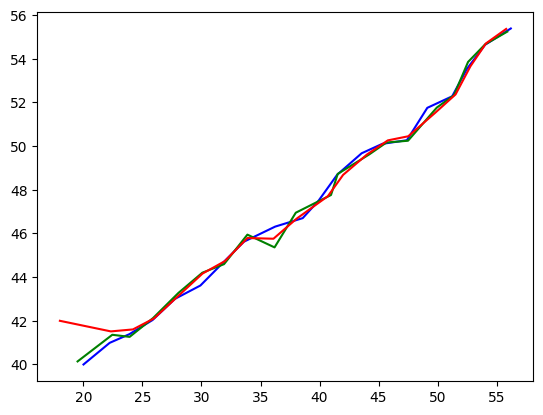

In [ ]:
plt.plot(Pos[0,:],Pos[1,:],"b")
plt.plot(Obs[0,:],Obs[1,:],'g')
plt.plot(Estimation[0,:],Estimation[1,:],'r')

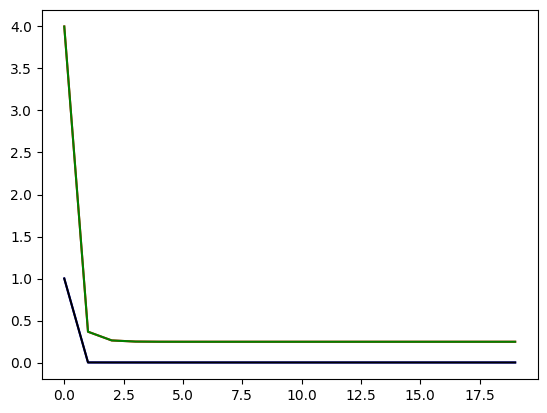

In [ ]:
plt.plot(range(TLen),P[0,0,:],'r')
plt.plot(range(TLen),P[1,1,:],'g')
plt.plot(range(TLen),P[2,2,:],'b')
plt.plot(range(TLen),P[3,3,:],'k')